In [3]:
import pandas as pd
import numpy as np
import sys, os
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import statsmodels.formula.api as smf
from sklearn.model_selection import KFold
import statsmodels.api as sm
pd.set_option('display.max_columns', 50)
import matplotlib.cm as cm


# Import Data and Split

In [4]:
training_data_cleaned = pd.read_pickle("./Full_data.pkl")     ## Load in the cleaned data

In [5]:
A_1619 = training_data_cleaned['ID'] == 'A-1619'
A_1611 = training_data_cleaned['ID'] == 'A-1611'
A_1620 = training_data_cleaned['ID'] == 'A-1620'
A_1637 = training_data_cleaned['ID'] == 'A-1637'
IDs = {'A-1619' : A_1619, 'A-1611' : A_1611, 'A-1620' : A_1620, 'A-1637' : A_1637}

In [6]:
for id_ in IDs:
    training_data_cleaned.loc[IDs[id_], 'kWh'] = training_data_cleaned[IDs[id_]].kWh/np.mean(training_data_cleaned[IDs[id_]].kWh)

In [7]:
training_data_cleaned = training_data_cleaned.drop(columns = ['timeStamp_y'])
training_data_cleaned.columns = training_data_cleaned.columns.str.replace(' ', '')
training_data_cleaned = training_data_cleaned.dropna()

In [8]:
training_data_cleaned = training_data_cleaned.drop(columns=['id', 'Flag']) 
training_data_cleaned.kWh = training_data_cleaned.kWh  / np.mean(training_data_cleaned.kWh )

In [9]:
test_set = training_data_cleaned.loc[training_data_cleaned["Year"] == 2016]
training_set = training_data_cleaned.loc[training_data_cleaned["Year"] < 2016]

In [10]:
training_set.ID.unique()

array(['A-1611', 'A-1619', 'A-1620', 'A-1637'], dtype=object)

In [11]:
def get_MSE(predictions, y):
    return np.mean((y-predictions)**2)

In [12]:
predictors = training_data_cleaned.columns
predictors = list(predictors)
predictors.remove('kWh')
predictors.remove('ID')
predictors.remove('Year')
predictors.remove('timeStamp_x')

predictors

['Month',
 'Day',
 'Hour',
 'Minute',
 'RelativeHumidity',
 'DewPoint',
 'SurfaceAlbedo',
 'PrecipitableWater',
 'Pressure',
 'GHI',
 'DHI',
 'DNI',
 'WindSpeed',
 'Temperature',
 'SolarZenithAngle',
 'ClearskyGHI',
 'ClearskyDNI',
 'ClearskyDHI',
 'lat',
 'lang',
 'CloudType_0',
 'CloudType_1',
 'CloudType_2',
 'CloudType_3',
 'CloudType_4',
 'CloudType_6',
 'CloudType_7',
 'CloudType_8',
 'CloudType_9',
 'CloudType_10']

# Data Exploration - Dataframes

In [13]:
training_data_cleaned.head()

,ID,kWh,timeStamp_x,Year,Month,Day,Hour,Minute,RelativeHumidity,DewPoint,SurfaceAlbedo,PrecipitableWater,Pressure,GHI,DHI,DNI,WindSpeed,Temperature,SolarZenithAngle,ClearskyGHI,ClearskyDNI,ClearskyDHI,lat,lang,CloudType_0,CloudType_1,CloudType_2,CloudType_3,CloudType_4,CloudType_6,CloudType_7,CloudType_8,CloudType_9,CloudType_10
data_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A-1611_2010-08-26 00:00:00,A-1611,0.007674,2010-08-26 00:00:00,2010,8,26,0,0,32.64,6,0.191,2.963,990.0,0,0,0,2.5,24,133.37,0,0,0,36.199249,-120.099385,1,0,0,0,0,0,0,0,0,0
A-1611_2010-08-26 00:30:00,A-1611,0.007674,2010-08-26 00:30:00,2010,8,26,0,30,34.66,6,0.191,2.988,990.0,0,0,0,2.4,24,132.93,0,0,0,36.199249,-120.099385,1,0,0,0,0,0,0,0,0,0
A-1611_2010-08-26 01:00:00,A-1611,0.007556,2010-08-26 01:00:00,2010,8,26,1,0,34.80,6,0.191,3.014,990.0,0,0,0,2.4,24,131.44,0,0,0,36.199249,-120.099385,1,0,0,0,0,0,0,0,0,0
A-1611_2010-08-26 01:30:00,A-1611,0.007556,2010-08-26 01:30:00,2010,8,26,1,30,34.80,6,0.191,3.035,990.0,0,0,0,2.3,24,129.02,0,0,0,36.199249,-120.099385,1,0,0,0,0,0,0,0,0,0
A-1611_2010-08-26 02:00:00,A-1611,0.007556,2010-08-26 02:00:00,2010,8,26,2,0,34.66,6,0.191,3.056,990.0,0,0,0,2.3,24,125.78,0,0,0,36.199249,-120.099385,1,0,0,0,0,0,0,0,0,0


In [14]:
training_data_cleaned.corr()

,kWh,Year,Month,Day,Hour,Minute,RelativeHumidity,DewPoint,SurfaceAlbedo,PrecipitableWater,Pressure,GHI,DHI,DNI,WindSpeed,Temperature,SolarZenithAngle,ClearskyGHI,ClearskyDNI,ClearskyDHI,lat,lang,CloudType_0,CloudType_1,CloudType_2,CloudType_3,CloudType_4,CloudType_6,CloudType_7,CloudType_8,CloudType_9,CloudType_10
kWh,1.000000e+00,0.018935,-0.076135,-0.003898,0.027362,0.000108,-0.616558,-0.037194,0.172678,-0.004000,-0.031000,0.928595,0.679851,0.820182,0.344940,0.601185,-0.793245,0.915665,0.831188,0.810031,-1.815826e-13,-1.764105e-13,0.190619,-0.113230,0.123077,-0.031740,-0.099735,-0.061045,-0.086178,-0.026144,-0.017836,-0.002355
Year,1.893497e-02,1.000000,-0.117918,-0.008918,0.000237,0.000026,-0.060939,0.067485,0.217585,0.038560,-0.041329,0.032079,0.019073,0.029386,0.054896,0.113415,-0.026850,0.022008,0.013938,0.018650,-7.216336e-02,1.756149e-01,-0.088940,0.128444,0.027437,0.001911,0.008900,-0.004008,-0.110835,0.139977,0.020157,-0.009571
Month,-7.613488e-02,-0.117918,1.000000,0.011955,-0.000237,-0.000027,-0.143626,-0.003878,-0.172992,0.102962,-0.062626,-0.042282,-0.082662,-0.004759,-0.024342,0.138435,0.066773,-0.058395,-0.029864,-0.078234,-3.601524e-02,3.075747e-02,0.065938,0.002804,-0.013532,-0.006363,-0.045619,-0.014931,-0.017698,-0.051477,-0.011052,0.000966
Day,-3.897587e-03,-0.008918,0.011955,1.000000,-0.000160,0.000055,0.008564,0.003094,-0.020952,0.016561,-0.000025,-0.000720,-0.010557,0.003111,0.019587,-0.003778,0.000725,-0.000795,0.001367,-0.006935,-5.697077e-04,-6.276993e-04,0.009969,0.004850,0.004102,0.001021,-0.002171,0.006545,-0.008549,-0.026178,-0.002448,0.002904
Hour,2.736154e-02,0.000237,-0.000237,-0.000160,1.000000,-0.000038,-0.176579,0.005305,-0.000140,-0.002503,-0.016240,0.041921,0.032752,0.051037,0.124018,0.170932,-0.071574,0.040105,0.047629,0.044487,1.145665e-05,-3.287182e-05,0.031788,-0.032261,0.015977,-0.006743,-0.028497,-0.000700,0.007881,0.000029,0.000023,0.000868
Minute,1.081070e-04,0.000026,-0.000027,0.000055,-0.000038,1.000000,0.012750,-0.004184,-0.000012,-0.000217,-0.001611,-0.000216,0.000730,-0.000029,-0.010968,-0.014960,-0.000014,-0.000004,0.000285,0.000598,6.715233e-05,-1.025169e-04,-0.000745,0.000207,-0.000803,-0.002301,0.001977,0.000455,-0.000388,0.001991,0.000665,0.001002
RelativeHumidity,-6.165582e-01,-0.060939,-0.143626,0.008564,-0.176579,0.012750,1.000000,0.349671,-0.359923,0.103043,0.298073,-0.686796,-0.456644,-0.689916,-0.295549,-0.787925,0.614727,-0.651925,-0.648275,-0.577154,5.933931e-02,-2.684843e-01,-0.247531,0.052119,-0.066490,0.031543,0.136160,0.094754,0.135782,0.083842,0.027634,0.004502
DewPoint,-3.719370e-02,0.067485,-0.003878,0.003094,0.005305,-0.004184,0.349671,1.000000,0.111814,0.625194,-0.003578,-0.029420,0.057941,-0.092687,0.106055,0.216088,-0.064752,0.004167,-0.031020,0.042572,5.818678e-02,-1.865124e-01,-0.036547,-0.079378,0.004646,0.086467,-0.022124,0.047240,0.032581,0.064279,0.014023,-0.002811
SurfaceAlbedo,1.726775e-01,0.217585,-0.172992,-0.020952,-0.000140,-0.000012,-0.359923,0.111814,1.000000,0.127318,-0.591995,0.210820,0.123702,0.159896,0.224214,0.459578,-0.226930,0.188215,0.108657,0.165580,-3.169552e-01,5.763561e-01,0.118432,0.057702,0.005590,0.003249,-0.100537,-0.073169,-0.115447,-0.036428,-0.011386,-0.003021
PrecipitableWater,-3.999825e-03,0.038560,0.102962,0.016561,-0.002503,-0.000217,0.103043,0.625194,0.127318,1.000000,-0.114933,0.009537,0.130412,-0.085071,0.132977,0.289092,-0.091247,0.064396,0.016136,0.112073,-2.415907e-02,-2.510361e-03,-0.202050,-0.061281,0.023121,0.084467,0.088179,0.124912,0.121464,0.099434,0.030026,-0.000600


In [15]:
training_data_cleaned["CloudType_10"]

data_id
A-1611_2010-08-26 00:00:00    0
A-1611_2010-08-26 00:30:00    0
A-1611_2010-08-26 01:00:00    0
A-1611_2010-08-26 01:30:00    0
A-1611_2010-08-26 02:00:00    0
                             ..
A-1637_2016-12-30 21:30:00    0
A-1637_2016-12-30 22:00:00    0
A-1637_2016-12-30 22:30:00    0
A-1637_2016-12-30 23:00:00    0
A-1637_2016-12-30 23:30:00    0
Name: CloudType_10, Length: 747870, dtype: uint8

In [16]:
a = training_data_cleaned.loc[training_data_cleaned["CloudType_10"] == 1]
a

,ID,kWh,timeStamp_x,Year,Month,Day,Hour,Minute,RelativeHumidity,DewPoint,SurfaceAlbedo,PrecipitableWater,Pressure,GHI,DHI,DNI,WindSpeed,Temperature,SolarZenithAngle,ClearskyGHI,ClearskyDNI,ClearskyDHI,lat,lang,CloudType_0,CloudType_1,CloudType_2,CloudType_3,CloudType_4,CloudType_6,CloudType_7,CloudType_8,CloudType_9,CloudType_10
data_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A-1611_2011-03-21 22:00:00,A-1611,0.007202,2011-03-21 22:00:00,2011,3,21,22,0,100.00,4,0.168,1.299,1000.0,0,0,0,1.2,6,132.85,0,0,0,36.199249,-120.099385,0,0,0,0,0,0,0,0,0,1
A-1611_2011-04-22 20:00:00,A-1611,0.007320,2011-04-22 20:00:00,2011,4,22,20,0,85.12,9,0.172,2.161,1000.0,0,0,0,2.0,13,105.69,0,0,0,36.199249,-120.099385,0,0,0,0,0,0,0,0,0,1
A-1619_2010-11-20 17:30:00,A-1619,0.008072,2010-11-20 17:30:00,2010,11,20,17,30,96.35,7,0.133,1.811,1010.0,0,0,0,5.1,10,97.44,0,0,0,37.354113,-121.955174,0,0,0,0,0,0,0,0,0,1
A-1619_2010-11-20 17:30:00,A-1619,0.008072,2010-11-20 17:30:00,2010,11,20,17,30,96.35,7,0.133,1.811,1010.0,0,0,0,5.1,10,97.44,0,0,0,37.354113,-121.955174,0,0,0,0,0,0,0,0,0,1
A-1619_2010-11-20 17:30:00,A-1619,0.008072,2010-11-20 17:30:00,2010,11,20,17,30,96.35,7,0.133,1.811,1010.0,0,0,0,5.1,10,97.44,0,0,0,37.354113,-121.955174,0,0,0,0,0,0,0,0,0,1
A-1619_2010-11-20 17:30:00,A-1619,0.008072,2010-11-20 17:30:00,2010,11,20,17,30,96.35,7,0.133,1.811,1010.0,0,0,0,5.1,10,97.44,0,0,0,37.354113,-121.955174,0,0,0,0,0,0,0,0,0,1
A-1619_2010-11-20 17:30:00,A-1619,0.008072,2010-11-20 17:30:00,2010,11,20,17,30,96.35,7,0.133,1.811,1010.0,0,0,0,5.1,10,97.44,0,0,0,37.354113,-121.955174,0,0,0,0,0,0,0,0,0,1
A-1619_2010-12-21 01:00:00,A-1619,0.008072,2010-12-21 01:00:00,2010,12,21,1,0,100.00,4,0.133,1.401,1010.0,0,0,0,1.6,6,161.85,0,0,0,37.354113,-121.955174,0,0,0,0,0,0,0,0,0,1
A-1619_2010-12-21 01:00:00,A-1619,0.008072,2010-12-21 01:00:00,2010,12,21,1,0,100.00,4,0.133,1.401,1010.0,0,0,0,1.6,6,161.85,0,0,0,37.354113,-121.955174,0,0,0,0,0,0,0,0,0,1


## Correlation Matrix

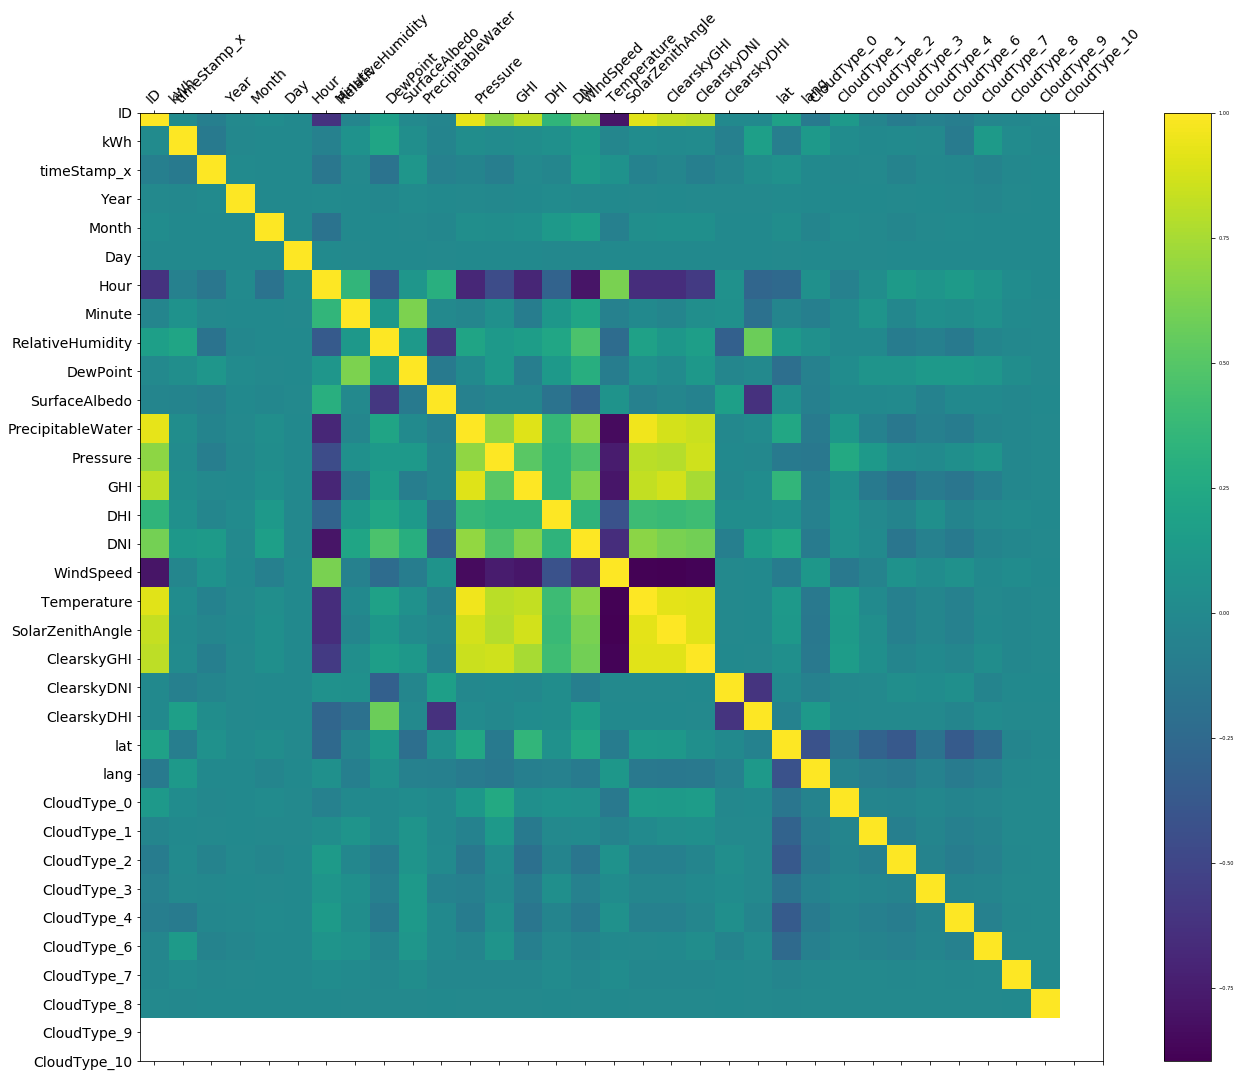

In [17]:
f = plt.figure(figsize=(22, 17))
plt.matshow(training_data_cleaned.corr(), fignum=f.number)
plt.xticks(range(training_data_cleaned.shape[1]), training_data_cleaned.columns, fontsize=14, rotation=45)
plt.yticks(range(training_data_cleaned.shape[1]), training_data_cleaned.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=5)

Note: Cloud Type 10 has all 0 values EXCEPT for 2 rows. This is why the correlation appears white above.

# Data Exploration - Energy to Time

In [18]:
hash_table = {key: i_str for i_str, key in enumerate(training_data_cleaned.ID)}
mpl_cmap = cm.get_cmap('viridis', lut=len(training_data_cleaned.ID))
training_data_cleaned['hash'] = training_data_cleaned.ID.apply(lambda x: hash_table[x])

In [19]:
def scatter_plot(feature, target):
    plt.figure(figsize=(16, 8))
    plt.scatter(
        training_data_cleaned[feature][::97],
        training_data_cleaned[target][::97],
        c=(mpl_cmap(training_data_cleaned.hash[::97]))
    )
    plt.xlabel("Predictor {}".format(feature))
    plt.ylabel("Solar Energy {}".format(target))
    plt.show()

In [20]:
training_data_cleaned['Year'].unique()

array([2010, 2011, 2012, 2013, 2014, 2015, 2016], dtype=int64)

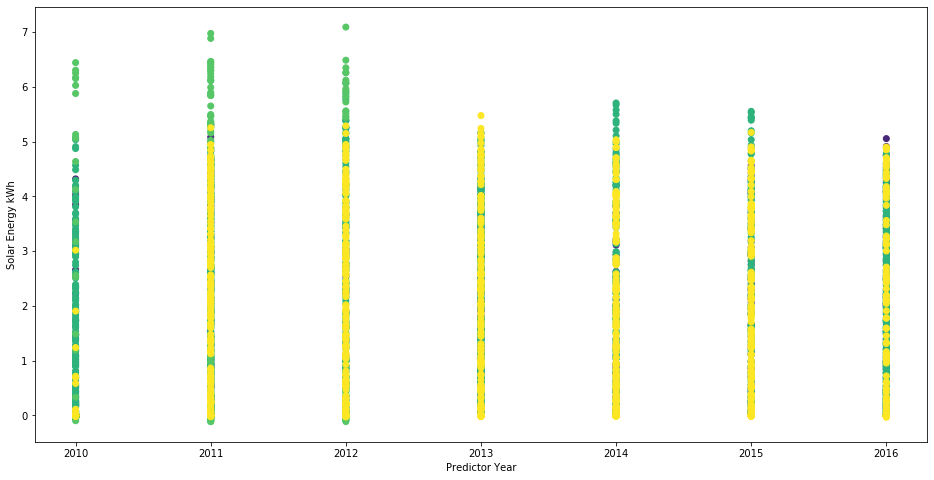

In [21]:
scatter_plot('Year','kWh')

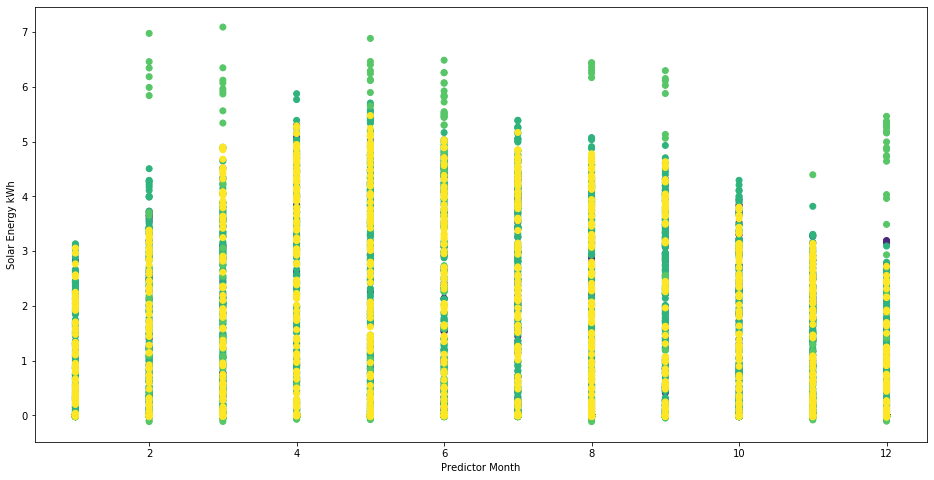

In [22]:
scatter_plot('Month','kWh')

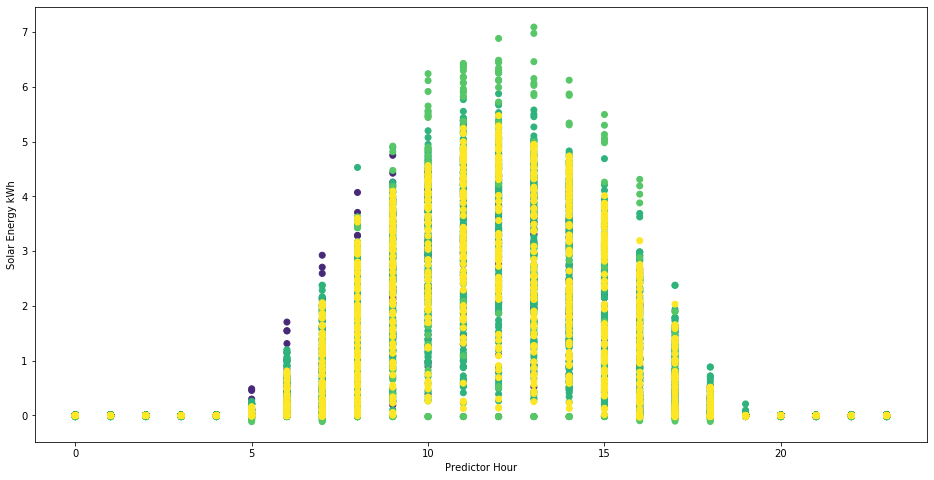

In [23]:
scatter_plot('Hour','kWh')

# Data Exploration - Energy to Weather

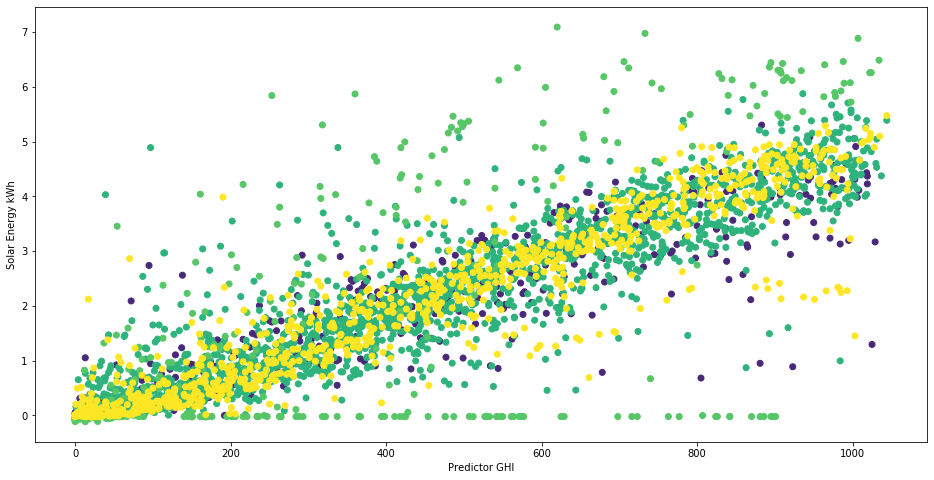

In [24]:
scatter_plot('GHI','kWh')

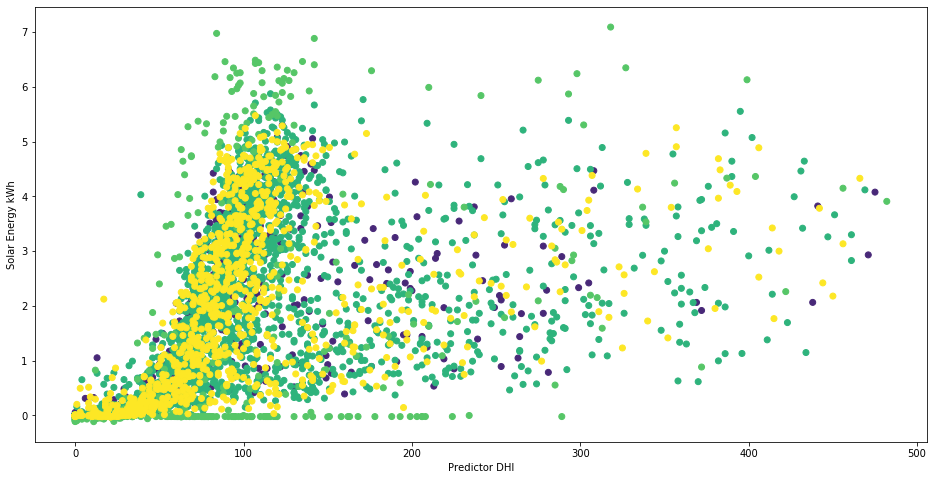

In [25]:
scatter_plot('DHI','kWh')

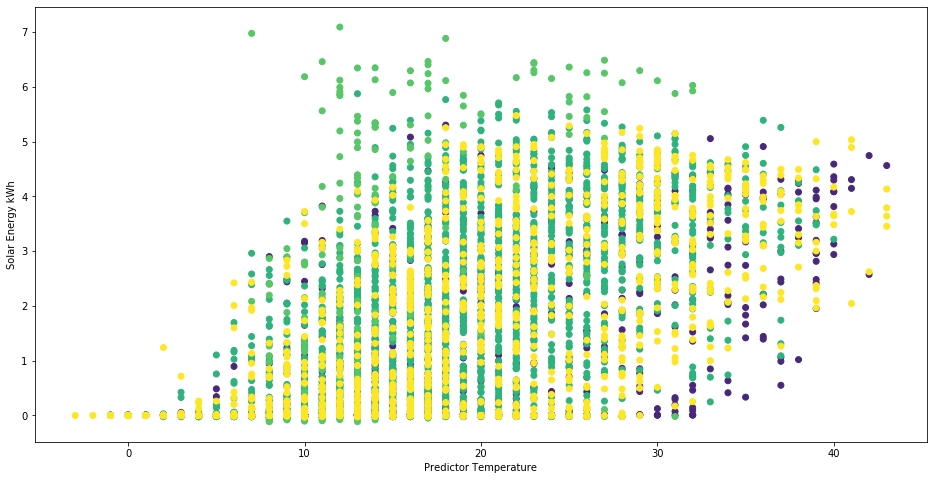

In [26]:
scatter_plot('Temperature','kWh')

# Model Selection - Forward Selection
Using k = 5 k-fold cross validation and forward selection, we find that the model with the following features:

GHI + Temperature + ClearskyGHI + DewPoint + RelativeHumidity + CloudType6 + CloudType2 + Pressure + CloudType3 + PrecipitableWater + WindSpeed + CloudType4 + CloudType0 + SolarZenithAngle + DNI + ClearskyDNI 

Although forward selection may not find the BEST combination of features, this method is heuristic and provides an efficient and practical model fit.

In [27]:
def get_k_folds(k, set) :
    set_random = set.sample(frac=1).reset_index(drop=True)
    return np.array_split(set_random, k) 

In [28]:
train_input = training_set[predictors]

In [29]:
training_set.head(2)

,ID,kWh,timeStamp_x,Year,Month,Day,Hour,Minute,RelativeHumidity,DewPoint,SurfaceAlbedo,PrecipitableWater,Pressure,GHI,DHI,DNI,WindSpeed,Temperature,SolarZenithAngle,ClearskyGHI,ClearskyDNI,ClearskyDHI,lat,lang,CloudType_0,CloudType_1,CloudType_2,CloudType_3,CloudType_4,CloudType_6,CloudType_7,CloudType_8,CloudType_9,CloudType_10
data_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A-1611_2010-08-26 00:00:00,A-1611,0.007674,2010-08-26 00:00:00,2010,8,26,0,0,32.64,6,0.191,2.963,990.0,0,0,0,2.5,24,133.37,0,0,0,36.199249,-120.099385,1,0,0,0,0,0,0,0,0,0
A-1611_2010-08-26 00:30:00,A-1611,0.007674,2010-08-26 00:30:00,2010,8,26,0,30,34.66,6,0.191,2.988,990.0,0,0,0,2.4,24,132.93,0,0,0,36.199249,-120.099385,1,0,0,0,0,0,0,0,0,0


In [30]:
predictors_temp = predictors


In [31]:
train_input.columns

Index(['Month', 'Day', 'Hour', 'Minute', 'RelativeHumidity', 'DewPoint',
       'SurfaceAlbedo', 'PrecipitableWater', 'Pressure', 'GHI', 'DHI', 'DNI',
       'WindSpeed', 'Temperature', 'SolarZenithAngle', 'ClearskyGHI',
       'ClearskyDNI', 'ClearskyDHI', 'lat', 'lang', 'CloudType_0',
       'CloudType_1', 'CloudType_2', 'CloudType_3', 'CloudType_4',
       'CloudType_6', 'CloudType_7', 'CloudType_8', 'CloudType_9',
       'CloudType_10'],
      dtype='object')

In [32]:
model = sm.OLS(training_set.kWh, sm.tools.add_constant(training_set[['GHI',
        'ClearskyGHI','Temperature']].values)).fit()



In [33]:
print(get_MSE(training_set.kWh, model.predict(sm.tools.add_constant(training_set[['GHI',
        'ClearskyGHI','Temperature']].values))))


    

0.3015890590334183


In [34]:
sm.tools.add_constant(test_set[['GHI','ClearskyGHI','Temperature']].values)

array([[1., 0., 0., 3.],
       [1., 0., 0., 3.],
       [1., 0., 0., 3.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

In [35]:
print(get_MSE(test_set.kWh,model.predict(sm.tools.add_constant(test_set[['GHI','ClearskyGHI','Temperature']].values))))

0.22232488865809705


In [36]:
train_error = {}
test_error = {}
used_predicters = []
for p in predictors:
    sub_data = train_input.drop(columns = used_predicters)
    mse = []; 
    for p in sub_data:
        curent_predictors = used_predicters + [p]
        model = sm.OLS(training_set.kWh, sm.tools.add_constant(training_set[curent_predictors].values)).fit()
        # Step 2: Find the predicted values using the current model
        yhat = model.predict(sm.tools.add_constant((training_set[curent_predictors].values)))
        # Step 3: Find the MSE for the current model and save
        mse.append(get_MSE(yhat, training_set.kWh))
    used_predicters += [sub_data.columns[mse.index(min(mse))]]
    
    k_data = training_set

    folds = get_k_folds(5, k_data)
    indices = np.arange(5)

    train_error_sub = []
    test_error_sub = []
    for i in range(0, len(folds)) :
        trainig_set_temp = pd.concat(folds[:i] + folds[i+1:])
        testing_set = folds[i]
        model = sm.OLS(trainig_set_temp.kWh, sm.tools.add_constant(trainig_set_temp[used_predicters].values)).fit()

        train_error_sub.append(get_MSE(trainig_set_temp.kWh, model.predict(sm.tools.add_constant(trainig_set_temp[used_predicters].values))))
        test_error_sub.append(get_MSE(testing_set.kWh,model.predict(sm.tools.add_constant(testing_set[used_predicters].values))))
    
    train_error[len(used_predicters)] = np.mean(train_error_sub)
    test_error[len(used_predicters)] = np.mean(test_error_sub)

It seems like we should include  29


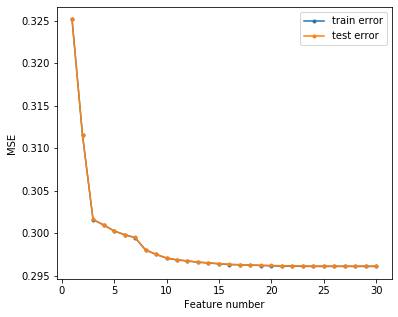

In [37]:
plt.figure(figsize=(6,5))

train_error_list = sorted(train_error.items()) # sorted by key, return a list of tuples
x, y_train = zip(*train_error_list)
test_error_list = sorted(test_error.items()) # sorted by key, return a list of tuples
x, y_test = zip(*test_error_list)
plt.plot(x,y_train, marker=".", label="train error")
plt.plot(x,y_test, marker=".", label="test error")

plt.legend()
plt.ylabel('MSE')
plt.xlabel('Feature number');
print('It seems like we should include ', y_test.index(min(y_test)))

In [38]:
used_predicters

['GHI',
 'ClearskyGHI',
 'Temperature',
 'Month',
 'ClearskyDHI',
 'CloudType_2',
 'RelativeHumidity',
 'DewPoint',
 'Pressure',
 'ClearskyDNI',
 'CloudType_3',
 'CloudType_4',
 'CloudType_0',
 'SolarZenithAngle',
 'DHI',
 'PrecipitableWater',
 'CloudType_6',
 'lang',
 'DNI',
 'lat',
 'Hour',
 'Day',
 'CloudType_7',
 'SurfaceAlbedo',
 'Minute',
 'WindSpeed',
 'CloudType_9',
 'CloudType_10',
 'CloudType_1',
 'CloudType_8']

In [39]:
test_set.columns

Index(['ID', 'kWh', 'timeStamp_x', 'Year', 'Month', 'Day', 'Hour', 'Minute',
       'RelativeHumidity', 'DewPoint', 'SurfaceAlbedo', 'PrecipitableWater',
       'Pressure', 'GHI', 'DHI', 'DNI', 'WindSpeed', 'Temperature',
       'SolarZenithAngle', 'ClearskyGHI', 'ClearskyDNI', 'ClearskyDHI', 'lat',
       'lang', 'CloudType_0', 'CloudType_1', 'CloudType_2', 'CloudType_3',
       'CloudType_4', 'CloudType_6', 'CloudType_7', 'CloudType_8',
       'CloudType_9', 'CloudType_10'],
      dtype='object')

In [40]:
sm.tools.add_constant(training_set[used_predicters[0:27]])


C:\Users\Tamuz\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,const,GHI,ClearskyGHI,Temperature,Month,ClearskyDHI,CloudType_2,RelativeHumidity,DewPoint,Pressure,ClearskyDNI,CloudType_3,CloudType_4,CloudType_0,SolarZenithAngle,DHI,PrecipitableWater,CloudType_6,lang,DNI,lat,Hour,Day,CloudType_7,SurfaceAlbedo,Minute,WindSpeed,CloudType_9
data_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A-1611_2010-08-26 00:00:00,1.0,0,0,24,8,0,0,32.64,6,990.0,0,0,0,1,133.37,0,2.963,0,-120.099385,0,36.199249,0,26,0,0.191,0,2.5,0
A-1611_2010-08-26 00:30:00,1.0,0,0,24,8,0,0,34.66,6,990.0,0,0,0,1,132.93,0,2.988,0,-120.099385,0,36.199249,0,26,0,0.191,30,2.4,0
A-1611_2010-08-26 01:00:00,1.0,0,0,24,8,0,0,34.80,6,990.0,0,0,0,1,131.44,0,3.014,0,-120.099385,0,36.199249,1,26,0,0.191,0,2.4,0
A-1611_2010-08-26 01:30:00,1.0,0,0,24,8,0,0,34.80,6,990.0,0,0,0,1,129.02,0,3.035,0,-120.099385,0,36.199249,1,26,0,0.191,30,2.3,0
A-1611_2010-08-26 02:00:00,1.0,0,0,24,8,0,0,34.66,6,990.0,0,0,0,1,125.78,0,3.056,0,-120.099385,0,36.199249,2,26,0,0.191,0,2.3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A-1637_2015-12-31 22:30:00,1.0,0,0,2,12,0,0,82.25,-1,1010.0,0,0,0,1,153.60,0,0.546,0,-121.738349,0,38.547502,22,31,0,0.139,30,3.2,0
A-1637_2015-12-31 23:00:00,1.0,0,0,2,12,0,0,80.99,-1,1010.0,0,0,0,1,158.43,0,0.537,0,-121.738349,0,38.547502,23,31,0,0.139,0,3.3,0
A-1637_2015-12-31 23:00:00,1.0,0,0,2,12,0,0,80.99,-1,1010.0,0,0,0,1,158.43,0,0.537,0,-121.738349,0,38.547502,23,31,0,0.139,0,3.3,0


In [41]:
training_set[used_predicters[0:28]].head(1)

,GHI,ClearskyGHI,Temperature,Month,ClearskyDHI,CloudType_2,RelativeHumidity,DewPoint,Pressure,ClearskyDNI,CloudType_3,CloudType_4,CloudType_0,SolarZenithAngle,DHI,PrecipitableWater,CloudType_6,lang,DNI,lat,Hour,Day,CloudType_7,SurfaceAlbedo,Minute,WindSpeed,CloudType_9,CloudType_10
data_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A-1611_2010-08-26 00:00:00,0,0,24,8,0,0,32.64,6,990.0,0,0,0,1,133.37,0,2.963,0,-120.099385,0,36.199249,0,26,0,0.191,0,2.5,0,0


In [42]:
test_set[used_predicters[0:28]].head(1)

,GHI,ClearskyGHI,Temperature,Month,ClearskyDHI,CloudType_2,RelativeHumidity,DewPoint,Pressure,ClearskyDNI,CloudType_3,CloudType_4,CloudType_0,SolarZenithAngle,DHI,PrecipitableWater,CloudType_6,lang,DNI,lat,Hour,Day,CloudType_7,SurfaceAlbedo,Minute,WindSpeed,CloudType_9,CloudType_10
data_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A-1611_2016-01-01 00:00:00,0,0,3,1,0,0,82.63,0,1000.0,0,0,0,0,166.8,0,0.594,0,-120.099385,0,36.199249,0,1,0,0.158,0,0.8,0,0


In [43]:
sm.tools.add_constant(test_set[used_predicters[0:19]], prepend=True)

,const,GHI,ClearskyGHI,Temperature,Month,ClearskyDHI,CloudType_2,RelativeHumidity,DewPoint,Pressure,ClearskyDNI,CloudType_3,CloudType_4,CloudType_0,SolarZenithAngle,DHI,PrecipitableWater,CloudType_6,lang,DNI
data_id,,,,,,,,,,,,,,,,,,,,
A-1611_2016-01-01 00:00:00,1.0,0,0,3,1,0,0,82.63,0,1000.0,0,0,0,0,166.80,0,0.594,0,-120.099385,0
A-1611_2016-01-01 00:30:00,1.0,0,0,3,1,0,0,82.62,0,1000.0,0,0,0,0,165.64,0,0.570,0,-120.099385,0
A-1611_2016-01-01 01:00:00,1.0,0,0,3,1,0,0,81.52,0,1000.0,0,0,0,0,162.05,0,0.546,0,-120.099385,0
A-1611_2016-01-01 01:30:00,1.0,0,0,3,1,0,0,81.52,0,1000.0,0,0,0,0,157.16,0,0.522,0,-120.099385,0
A-1611_2016-01-01 02:00:00,1.0,0,0,3,1,0,0,78.68,-1,1000.0,0,0,0,0,151.64,0,0.498,0,-120.099385,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A-1637_2016-12-30 21:30:00,1.0,0,0,0,12,0,0,78.95,-3,1020.0,0,0,0,0,142.65,0,0.624,0,-121.738349,0
A-1637_2016-12-30 22:00:00,1.0,0,0,0,12,0,0,76.79,-3,1020.0,0,0,0,0,148.28,0,0.632,0,-121.738349,0
A-1637_2016-12-30 22:30:00,1.0,0,0,0,12,0,0,76.78,-3,1020.0,0,0,0,0,153.63,0,0.639,0,-121.738349,0


In [44]:
model = sm.OLS(training_set.kWh, sm.tools.add_constant(training_set[used_predicters[0:27]])).fit()
y_hat_train = model.predict(sm.tools.add_constant(training_set[used_predicters[0:27]]))

In [45]:
y_hat_test = model.predict(sm.tools.add_constant(test_set[used_predicters[0:27]], has_constant='add'))

In [46]:
test_set = test_set.astype({"ID": str})

In [47]:
hash_table = {key: i_str for i_str, key in enumerate(training_set.ID)}
mpl_cmap = cm.get_cmap('viridis', lut=len(training_set.ID))
training_set['hash'] = training_set.ID.apply(lambda x: hash_table[x])

C:\Users\Tamuz\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [48]:
hash_table = {key: i_str for i_str, key in enumerate(test_set.ID)}
mpl_cmap = cm.get_cmap('viridis', lut=len(test_set.ID))


In [49]:
training_set.ID.unique()

array(['A-1611', 'A-1619', 'A-1620', 'A-1637'], dtype=object)

In [50]:
test_set['hash'] = test_set.ID.apply(lambda x: hash_table[x])

No handles with labels found to put in legend.


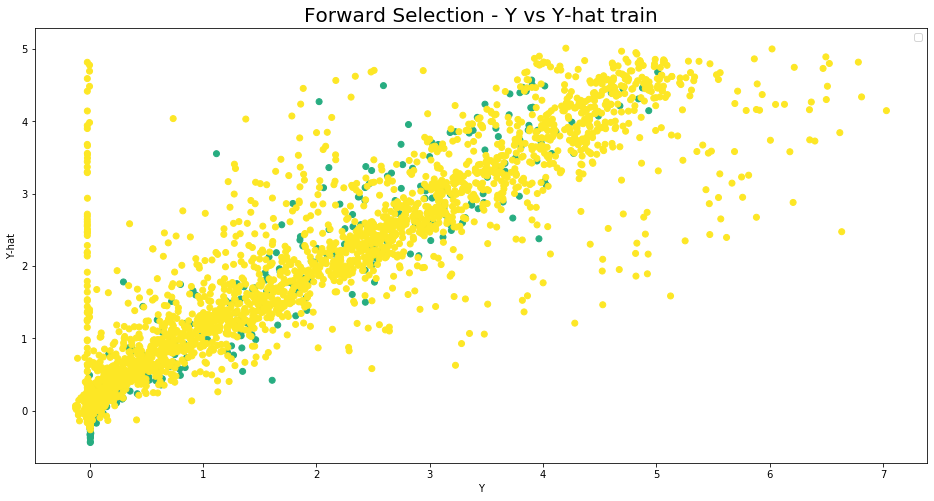

In [51]:
plt.figure(figsize=(16, 8))
plt.scatter(training_set["kWh"][::24*5+1],y_hat_train[::24*5+1], c=mpl_cmap(training_set.hash[::24*5+1]))
plt.xlabel("Y")
plt.ylabel("Y-hat")
plt.legend()
plt.title("Forward Selection - Y vs Y-hat train", size =20)
plt.show()

No handles with labels found to put in legend.


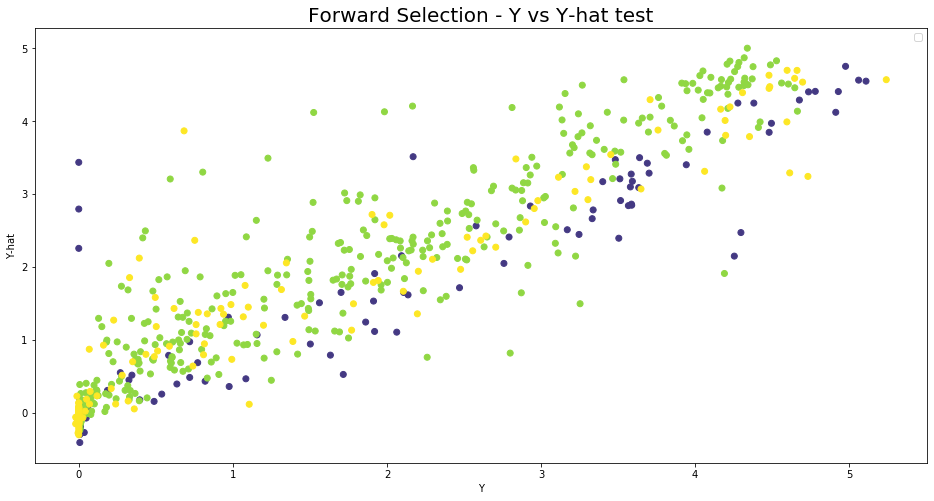

In [52]:
plt.figure(figsize=(16, 8))
plt.scatter(test_set["kWh"][::97],y_hat_test[::97], c=mpl_cmap(test_set.hash[::97]))
plt.xlabel("Y")
plt.ylabel("Y-hat")
plt.legend()
plt.title("Forward Selection - Y vs Y-hat test", size =20)
plt.show()

In [53]:
model.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    kWh   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                 1.634e+05
Date:                Wed, 04 Dec 2019   Prob (F-statistic):               0.00
Time:                        15:21:43   Log-Likelihood:            -5.2099e+05
No. Observations:              642906   AIC:                         1.042e+06
Df Residuals:                  642878   BIC:                         1.042e+06
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -4.6602      0.209    -22.329      0.000      -5.069      -4.251
GHI                   0.0036   2.21e-05    164.858      0.000       0.004       0.004
ClearskyGHI           0.0016   2.12e-05     77.416      0.000       0.002       0.002
Temperature          -0.0331      0.000   -107.375      0.000      -0.034      -0.032
Month                -0.0091      0.000    -40.563      0.000      -0.010      -0.009
ClearskyDHI          -0.0007   4.71e-05    -15.242      0.000      -0.001      -0.001
CloudType_2           0.2361      0.006     36.658      0.000       0.224       0.249
RelativeHumidity     -0.0066   9.41e-05    -70.205      0.000      -0.007      -0.006
DewPoint              0.0219      0.000     60.655      0.000       0.021       0.023
Pressure              0.0023      0.000     19.821      0.000       0.002       0.003
ClearskyDNI       -6.775e-05   1.13e-05     -5.996      0.000   -8.99e-05   -4.56e-05
CloudType_3           0.0949      0.004     25.267      0.000       0.088       0.102
CloudType_4           0.0629      0.003     19.630      0.000       0.057       0.069
CloudType_0           0.0282      0.002     11.849      0.000       0.024       0.033
SolarZenithAngle      0.0008   4.72e-05     16.024      0.000       0.001       0.001
DHI                  -0.0004   2.42e-05    -17.590      0.000      -0.000      -0.000
PrecipitableWater    -0.0179      0.001    -12.333      0.000      -0.021      -0.015
CloudType_6          -0.0349      0.005     -6.543      0.000      -0.045      -0.024
lang                 -0.0287      0.002    -13.907      0.000      -0.033      -0.025
DNI                  -0.0001    1.2e-05     -8.387      0.000      -0.000   -7.69e-05
lat                  -0.0120      0.001     -9.227      0.000      -0.015      -0.009
Hour                 -0.0008      0.000     -7.277      0.000      -0.001      -0.001
Day                  -0.0005   7.74e-05     -5.965      0.000      -0.001      -0.000
CloudType_7           0.0192      0.003      6.083      0.000       0.013       0.025
SurfaceAlbedo         0.4232      0.094      4.505      0.000       0.239       0.607
Minute            -4.763e-05   4.53e-05     -1.052      0.293      -0.000    4.11e-05
WindSpeed            -0.0005      0.001     -0.740      0.459      -0.002       0.001
CloudType_9           0.0200      0.028      0.702      0.483      -0.036       0.076
==============================================================================
Omnibus:                   246421.628   Durbin-Watson:                   0.126
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         11199709.354
Skew:                          -1.117   Prob(JB):                         0.00
Kurtosis:                      23.325   Cond. No.                     3.92e+05
======================

In [54]:
test_set[test_set.ID == 'A-1611'].index

Index(['A-1611_2016-01-01 00:00:00', 'A-1611_2016-01-01 00:30:00',
       'A-1611_2016-01-01 01:00:00', 'A-1611_2016-01-01 01:30:00',
       'A-1611_2016-01-01 02:00:00', 'A-1611_2016-01-01 02:30:00',
       'A-1611_2016-01-01 03:00:00', 'A-1611_2016-01-01 03:30:00',
       'A-1611_2016-01-01 04:00:00', 'A-1611_2016-01-01 04:30:00',
       ...
       'A-1611_2016-12-30 19:00:00', 'A-1611_2016-12-30 19:30:00',
       'A-1611_2016-12-30 20:00:00', 'A-1611_2016-12-30 20:30:00',
       'A-1611_2016-12-30 21:00:00', 'A-1611_2016-12-30 21:30:00',
       'A-1611_2016-12-30 22:00:00', 'A-1611_2016-12-30 22:30:00',
       'A-1611_2016-12-30 23:00:00', 'A-1611_2016-12-30 23:30:00'],
      dtype='object', name='data_id', length=17495)

C:\Users\Tamuz\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


<Figure size 864x360 with 0 Axes>

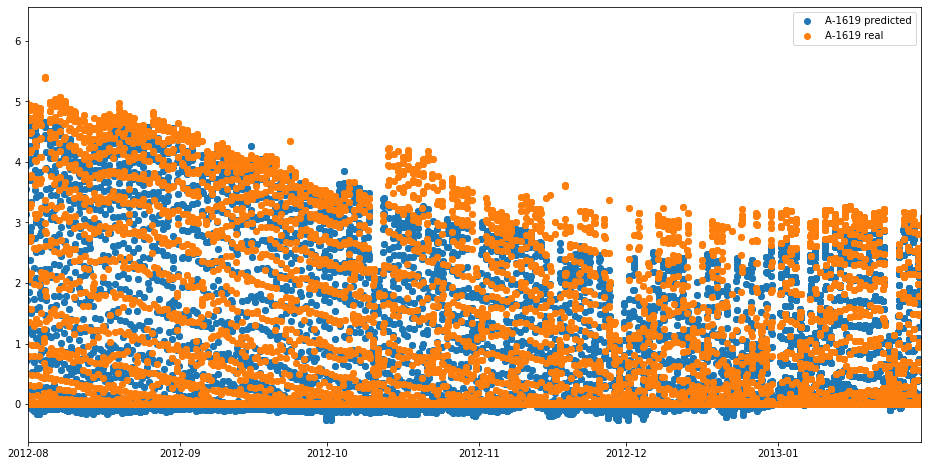

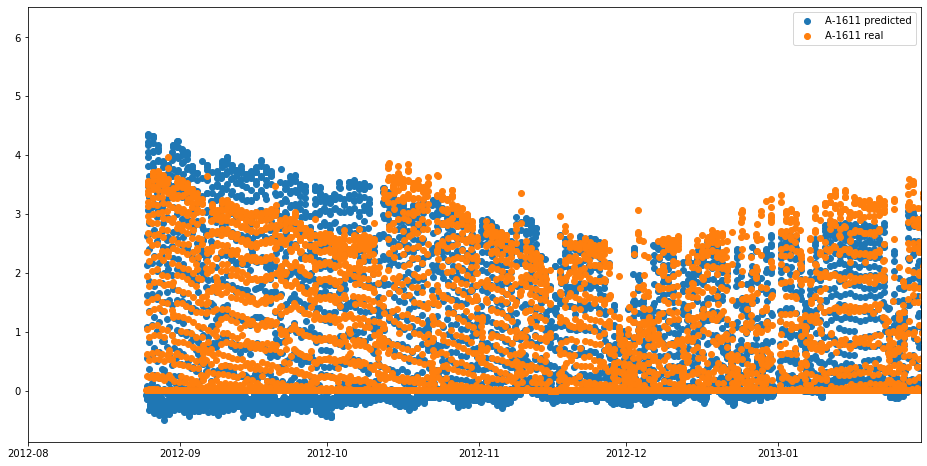

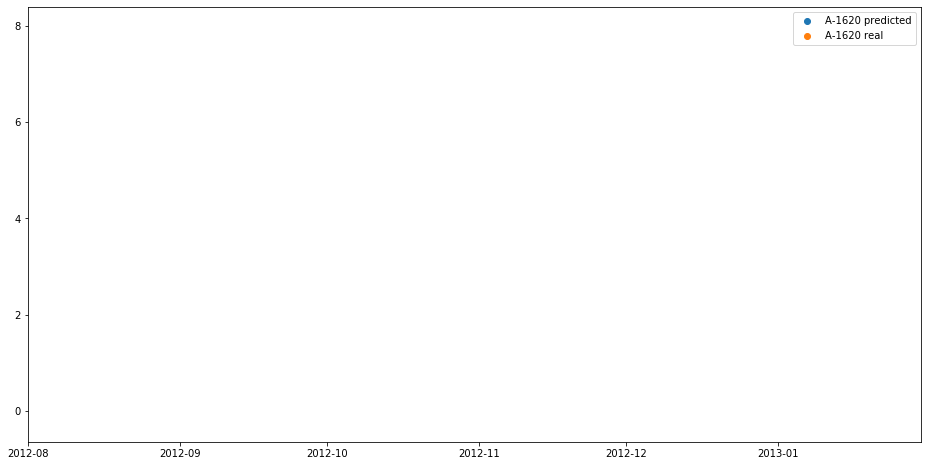

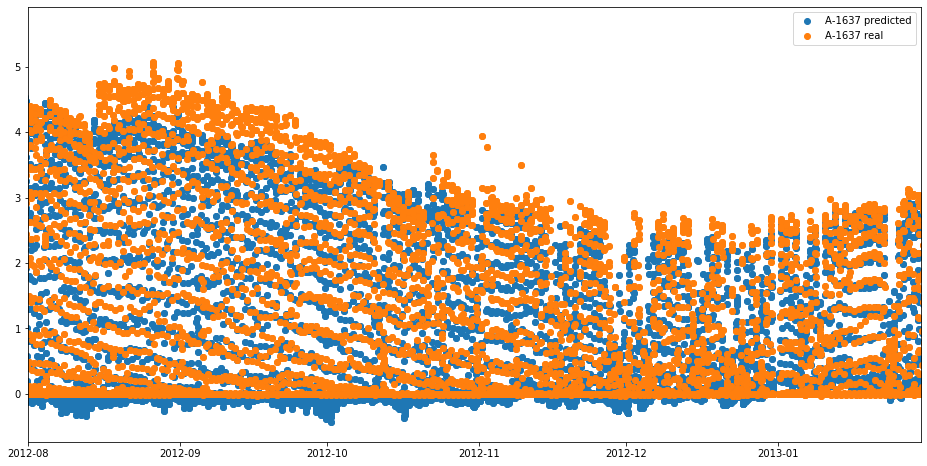

In [55]:
plt.figure(figsize=(12,5))


#plt.plot(test_set.index[::97],y_hat[::97], label="prediction", c=mpl_cmap(test_set.hash[::97]))
#plt.plot(test_set.index[::97],test_set.kWh[::97], label="real", c=mpl_cmap(test_set.hash[::97]))
#plt.xlim('2011-12-26 01:00:00', '2012-09-26 01:00:00')
#plt.legend()
#plt.ylabel('behiverial response')
#plt.xlabel('time');

for id_name in IDs:  
    plt.figure(figsize=(16, 8))
    plt.scatter(
        training_set[training_set.ID == id_name]['timeStamp_x'],
        y_hat_train[training_set.ID == id_name], label = id_name + ' predicted')
    plt.scatter(
        training_set[training_set.ID == id_name]['timeStamp_x'],
        training_set[training_set.ID == id_name]['kWh'], label = id_name + ' real')
    plt.legend()
    plt.xlim('2012-08-01-00','2013-01-30-00')
    plt.show()

In [56]:
y_19 = test_set[test_set.ID == 'A-1619'].kWh.values
y_hat_19 = y_hat_test[test_set.ID == 'A-1619'].values

In [57]:
toal_produced_y_19 = [y_19[0]]
for i in range(1, len(y_19)):
    toal_produced_y_19.append(y_19[i] + toal_produced_y_19[i-1]) 

In [58]:
toal_produced_y_hat_19 = [y_hat_19[0]]
for i in range(1, len(y_hat_19)):
    toal_produced_y_hat_19.append(y_hat_19[i] + toal_produced_y_hat_19[i-1]) 

In [59]:
len(toal_produced_y_19)

69980

In [60]:
len(toal_produced_y_hat_19)

69980

ValueError: x and y must have same first dimension, but have shapes (17489,) and (69980,)

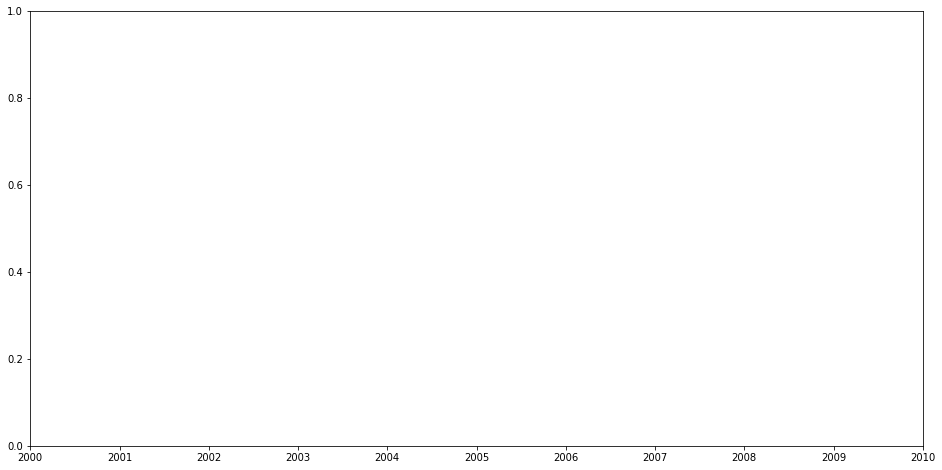

In [61]:
plt.figure(figsize=(16, 8))
plt.plot(
    test_set[test_set.ID == id_name]['timeStamp_x'],
    toal_produced_y_19, label = id_name + ' predicted')
plt.plot(
    test_set[test_set.ID == id_name]['timeStamp_x'],
    toal_produced_y_hat_19, label = id_name + ' real')
plt.legend()
# plt.xlim('2016-01-01-00','2016-01-30-00')
plt.show()

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(
    test_set[test_set.ID == id_name]['timeStamp_x'],
    np.array(toal_produced_y_hat_19) - np.array(toal_produced_y_19), label ='diffrence between predicted total output and real')
plt.legend()
# plt.xlim('2016-01-01-00','2016-01-30-00')
plt.show()

In [ ]:
plt.figure(figsize=(12,5))


#plt.plot(test_set.index[::97],y_hat[::97], label="prediction", c=mpl_cmap(test_set.hash[::97]))
#plt.plot(test_set.index[::97],test_set.kWh[::97], label="real", c=mpl_cmap(test_set.hash[::97]))
#plt.xlim('2011-12-26 01:00:00', '2012-09-26 01:00:00')
#plt.legend()
#plt.ylabel('behiverial response')
#plt.xlabel('time');

for id_name in IDs:  
    plt.figure(figsize=(16, 8))
    plt.plot(
        test_set[test_set.ID == id_name]['timeStamp_x'],
        y_hat_test[test_set.ID == id_name], label = id_name + ' predicted')
    plt.plot(
        test_set[test_set.ID == id_name]['timeStamp_x'],
        test_set[test_set.ID == id_name]['kWh'], label = id_name + ' real')
    plt.legend()
   # plt.xlim('2016-01-01-00','2016-01-30-00')
    plt.show()



In [ ]:
test_set.ID.unique()

# Model Selection - Linear, Lasso, and Ridge

In [ ]:
from sklearn.preprocessing import StandardScaler


In [ ]:
scaler = StandardScaler()
scaler.fit(training_set[used_predicters])

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

Xs = training_set[used_predicters]
y = training_set['kWh'].values.reshape(-1,1)

lin_reg = LinearRegression()

MSEs = cross_val_score(lin_reg, Xs, y, scoring='neg_mean_squared_error', cv=5)

mean_MSE = np.mean(MSEs)

print(mean_MSE)

In [ ]:
model = lin_reg.fit(Xs, y)

In [ ]:
y_hat = model.predict(test_set[used_predicters])

In [ ]:

for id_name in IDs:  
    plt.figure(figsize=(16, 8))
    plt.plot(
        test_set[test_set.ID == id_name]['timeStamp_x'][0:1000],
        y_hat[test_set.ID == id_name][0:1000], label = id_name + ' predicted')
    plt.plot(
        test_set[test_set.ID == id_name]['timeStamp_x'][0:1000],
        test_set[test_set.ID == id_name]['kWh'][0:1000], label = id_name + ' real')
    plt.legend()
    #plt.xlim('2016-01-01','2016-01-02')
    plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

alpha = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20, 40, 80, 160, 320, 640, 1280]

ridge = Ridge(max_iter=10000)

parameters = {'alpha': alpha}

ridge_regressor = GridSearchCV(ridge, parameters,scoring='neg_mean_squared_error', cv=5)

model = ridge_regressor.fit(Xs, y)

In [ ]:
ridge_regressor.best_params_

In [ ]:
ridge_regressor.best_score_


In [ ]:
y_hat = ridge_regressor.predict(test_set[predictors])

In [ ]:
for id_name in IDs:  
    plt.figure(figsize=(16, 8))
    plt.plot(
        test_set[test_set.ID == id_name]['timeStamp_x'][0:1000],
        y_hat[test_set.ID == id_name][0:1000], label = id_name + ' predicted')
    plt.plot(
        test_set[test_set.ID == id_name]['timeStamp_x'][0:1000],
        test_set[test_set.ID == id_name]['kWh'][0:1000], label = id_name + ' real')
    plt.legend()
    #plt.xlim('2016-01-01','2016-01-02')
    plt.show()

In [ ]:
from sklearn.linear_model import Lasso

lasso = Lasso()

parameters = {'alpha': alpha}

lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv = 5)

lasso_regressor.fit(Xs, y)

In [ ]:
lasso_regressor.best_params_

In [ ]:
lasso_regressor.best_score_

In [ ]:
lasso_regressor.fit(Xs, y)

In [ ]:
lasso = Lasso()
lasso()